### Calcium monitor demo
In this code we compare the Raw output (firing rate) with the **calcium monitor** output in a simulation of the mouse brain with stimulation of some of the regions.

###### Núria Tort-Colet

In [1]:
import tvb
from tvb.simulator.lab import *
import numpy as np

/Users/nuuria/ownCloud/TVB_models/new/tvb-root/scientific_library/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


INFO: this monitors.py version includes a calcium monitor


In [2]:
# simulation parameters:
from tvb_model_reference.simulation_file.parameter.nuu_parameter_Mouse_512 import Parameter
parameters = Parameter()

In [3]:
# model 
import tvb_model_reference.src.Zerlaut as zerlaut_model
my_model = zerlaut_model.Zerlaut_adaptation_second_order(\
                                              variables_of_interest=\
                                                 'E I C_ee C_ei C_ii W_e W_i noise'.split())

# parameters of the model from simulation file:
parameter_model = parameters.parameter_model

my_model.g_L=np.array(parameter_model['g_L'])
my_model.E_L_e=np.array(parameter_model['E_L_e'])
my_model.E_L_i=np.array(parameter_model['E_L_i'])
my_model.C_m=np.array(parameter_model['C_m'])
my_model.b_e=np.array(parameter_model['b_e'])
my_model.a_e=np.array(parameter_model['a_e'])
my_model.b_i=np.array(parameter_model['b_i'])
my_model.a_i=np.array(parameter_model['a_i'])
my_model.tau_w_e=np.array(parameter_model['tau_w_e'])
my_model.tau_w_i=np.array(parameter_model['tau_w_i'])
my_model.E_e=np.array(parameter_model['E_e'])
my_model.E_i=np.array(parameter_model['E_i'])
my_model.Q_e=np.array(parameter_model['Q_e'])
my_model.Q_i=np.array(parameter_model['Q_i'])
my_model.tau_e=np.array(parameter_model['tau_e'])
my_model.tau_i=np.array(parameter_model['tau_i'])
my_model.N_tot=np.array(parameter_model['N_tot'])
my_model.p_connect_e=np.array(parameter_model['p_connect_e'])
my_model.p_connect_i=np.array(parameter_model['p_connect_i'])
my_model.g=np.array(parameter_model['g'])
my_model.T=np.array(parameter_model['T'])
my_model.P_e=np.array(parameter_model['P_e'])
my_model.P_i=np.array(parameter_model['P_i'])
my_model.K_ext_e=np.array(parameter_model['K_ext_e'])
my_model.K_ext_i=np.array(parameter_model['K_ext_i'])
my_model.external_input_ex_ex=np.array(parameter_model['external_input_ex_ex'])
my_model.external_input_ex_in=np.array(parameter_model['external_input_ex_in'])
my_model.external_input_in_ex=np.array(parameter_model['external_input_in_ex'])
my_model.external_input_in_in=np.array(parameter_model['external_input_in_in'])
my_model.tau_OU=np.array(parameter_model['tau_OU'])
my_model.weight_noise=np.array(parameter_model['weight_noise'])
# 1rst order variables:
my_model.state_variable_range['E'] =np.array( parameter_model['initial_condition']['E'])
my_model.state_variable_range['I'] =np.array( parameter_model['initial_condition']['I'])
# 2nd order variables:
my_model.state_variable_range['C_ee'] = np.array(parameter_model['initial_condition']['C_ee'])
my_model.state_variable_range['C_ei'] = np.array(parameter_model['initial_condition']['C_ei'])
my_model.state_variable_range['C_ii'] = np.array(parameter_model['initial_condition']['C_ii'])
my_model.state_variable_range['W_e'] = np.array(parameter_model['initial_condition']['W_e'])
my_model.state_variable_range['W_i'] = np.array(parameter_model['initial_condition']['W_i'])

In [4]:
# connectivity (between regions)
path = parameters.parameter_connection_between_region['path']
my_connectivity = connectivity.Connectivity().from_file(path)

In [5]:
# coupling
my_coupling = coupling.Linear(a=np.array([0.0126]))

In [6]:
# integrator
my_noise = noise.Additive(nsig=np.array(parameters.parameter_integrator['noise_parameter']['nsig']),
                       ntau=parameters.parameter_integrator['noise_parameter']['ntau'],)
my_noise.random_stream.seed(parameters.parameter_simulation['seed'])

my_integrator = integrators.HeunStochastic(noise=my_noise,dt=parameters.parameter_integrator['dt'])

In [7]:
# monitors
my_monitors =[]
if parameters.parameter_monitor['Raw']:
    my_monitors.append(monitors.Raw())
if parameters.parameter_monitor['Ca']:
    monitor_Ca = monitors.Ca(
            variables_of_interest=np.array(
                parameters.parameter_monitor['parameter_Ca']['variables_of_interest']),
            tau_rise=parameters.parameter_monitor['parameter_Ca']['tau_rise'],
            tau_decay=parameters.parameter_monitor['parameter_Ca']['tau_decay'])
    my_monitors.append(monitor_Ca)

In [8]:
# stimulus 
num_regions = parameters.parameter_connection_between_region['number_of_regions']
weighting = np.zeros((num_regions, ))
weighting[[10,20,110,120,210,220,310,320,410,420]] = np.array(
    [1.4e-4, 1.4e-4, 1.2e-4, 1.2e-4, 1e-4, 1e-4, 0.8e-4, 0.8e-4, 0.6e-4, 0.6e-4])


eqn_t = equations.Gaussian()
eqn_t.parameters["midpoint"] = 3000.0
eqn_t.parameters["sigma"] = 100.0

my_stimulus = patterns.StimuliRegion(temporal=eqn_t,
                                  connectivity=my_connectivity,
                                  weight=weighting)

In [9]:
sim = simulator.Simulator(
    model = my_model,
    connectivity = my_connectivity,
    coupling = my_coupling,
    integrator = my_integrator,
    monitors = my_monitors,
    stimulus = my_stimulus,
    simulation_length = 5e3, # 5s simulation
).configure()


In [10]:
sim

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 99449c88-5c19-4d83-a9ff-f76160155125
coupling,Linear gid: 069609f4-5bed-4a3f-9c10-452e141b602e
gid,UUID('1a65c41f-50ea-4140-a23c-0d4a63e644c3')
initial_conditions,None
integrator,HeunStochastic gid: c1279b0b-e887-4a39-a573-57172232e41e
model,Zerlaut_adaptation_second_order gid: 0f0e9943-2c36-4c65-b560-2f1208c8a5c3
monitors,"[, ]"
simulation_length,5000.0


In [11]:
# run simulation
result = sim.run()

In [12]:
# simulation time and data for each monitor:

fr_time = result[0][0]
fr_data_e = result[0][1][:,0,:,0]*1e3 # from KHz to Hz, excitatory population
fr_data_i = result[0][1][:,1,:,0]*1e3 # from KHz to Hz, inhibitory population

ca_time = result[1][0]
ca_data_e = result[1][1][:,0,:] # excitatory population
ca_data_i = result[1][1][:,1,:] # inhibitory population

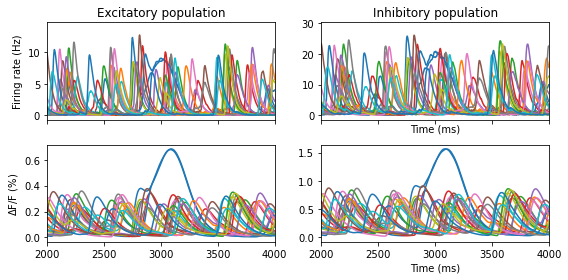

In [16]:
# plot the time series for (some) excitatory and inhibitory signals
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2, figsize=(8,4), sharex=True)
ax[0,0].plot(fr_time, fr_data_e[:,10:31])
ax[0,1].plot(fr_time, fr_data_i[:,10:31])
ax[1,0].plot(ca_time, ca_data_e[:,10:31])
ax[1,1].plot(ca_time, ca_data_i[:,10:31])

ax[0,0].set_title('Excitatory population')
ax[0,1].set_title('Inhibitory population')

ax[0,0].set_ylabel('Firing rate (Hz)')
ax[1,0].set_ylabel(r'$\Delta$F/F (%)')

ax[0,1].set_xlabel('Time (ms)')
ax[1,1].set_xlabel('Time (ms)')
ax[0,1].set_xlim(2000,4000)
ax[1,1].set_xlim(2000,4000)



plt.tight_layout()

plt.show()

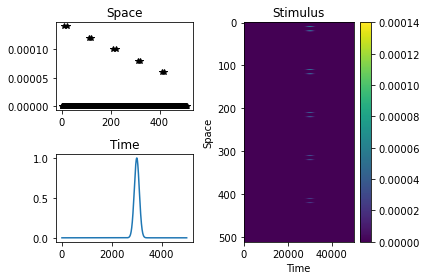

In [14]:
# plot stimulus pattern
plot_pattern(sim.stimulus)
plt.tight_layout()
plt.show()